In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
raw_data = pd.read_csv("survey_data.csv", header=1)
df = raw_data.iloc[:, 16:37].copy()
print("Data shape before cleaning:", df.shape)

q_ward = 'Which ward is this survey from?'
q_age = 'What is your age group?'
q_gender = 'What is your gender identity?'
q_race = 'With what ethnicity or race(s) do you most identify? (Check all that apply)'
q_education = 'What is your highest level of education?'
q_income = 'What is your annual household income?'
q_pol_party = 'How would you describe your political affiliation?'
q_conf_dir_us = 'Overall, do you feel that the country is heading in the right direction or the wrong direction?'
q_conf_dir_ri = 'Overall, do you feel that Rhode Island is heading in the right direction or the wrong direction?'
q_conf_pol_care = 'How confident are you that your Rhode Island politicians care about you?'
q_conf_elect_management = 'How confident are you in the ability of local voting officials to manage elections fairly and accurately?'
q_conf_elect_results = 'How confident are you that the results of the national presidential election will accurately reflect the votes cast?'
q_pres_vote = 'Who did you vote for President'
q_excited_vote = 'Were you excited to vote for your presidential candidate?'
q_info_sources = 'Where do you primarily get your information about voting options, such as precinct locations, voting times, early voting, and mail-in ballot options? (Select all that apply)'
q_in_person_reason = 'Why did you choose to vote in-person on election day? (Select all that apply)'

outcome_var = 'Would you support Rhode Island implementing ranked choice voting? This would allow voters to rank candidates in order of preference.'

demographics = [q_ward, q_age, q_gender, q_race, q_education, q_income, q_pol_party]
voter_confidence = [q_conf_dir_us, q_conf_dir_ri, q_conf_pol_care, q_conf_elect_management, q_conf_elect_results]
voter_behavior = [q_pres_vote, q_excited_vote, q_info_sources, q_in_person_reason]

required_columns = demographics + voter_confidence + voter_behavior


# Replace empty strings with NaN and drop rows missing any required fields
df[required_columns + [outcome_var]] = df[required_columns + [outcome_var]].replace("", np.nan)
df = df.dropna(subset=required_columns + [outcome_var])
print("Data shape after cleaning:", df.shape)

Data shape before cleaning: (558, 21)
Data shape after cleaning: (441, 21)


In [ ]:
support_map = {
    "Definitely Not": 1,
    "Probably Not": 2,
    "I would need more information to make a decision": 3,
    "Probably": 4,
    "Definitely": 5
}
df['outcome_ord'] = df[outcome_var].map(support_map)

# Drop rows where the outcome is ambiguous (value 3)
df_binary = df[df['outcome_ord'] != 3].copy()
print("Data shape after dropping rows with 'I would need more info':", df_binary.shape)

# Create binary outcome: 0 for responses 1 and 2; 1 for responses 4 and 5
df_binary['outcome_bin'] = df_binary['outcome_ord'].apply(lambda x: 0 if x in [1, 2] else 1)

df = df_binary.copy()

Data shape after dropping rows with 'I would need more info': (357, 22)


In [ ]:
# ordinal scales
age_order = ['18-24', '25-29', '30-39', '40-49', '50-64', '65 or older']
education_order = ['Less than High School', 'High school graduate / GED', 'Some college', '2 year degree', '4 year degree', 'Professional degree', 'Doctorate']
income_order = ['Less than $30,000', '30,000 - 49,999', '50,000 - 100,000', '100,000 - 199,999', '$200,000 or more']
confidence_order = ['Definitely Wrong', 'Somewhat Wrong', 'Unsure', 'Somewhat Right', 'Definitely Right']
excitement_order = ['Not at all Excited', 'Not Very Excited', 'Somewhat Excited', 'Very Excited', 'Extremely Excited']



# a. voter demographics
df['ward'] = df[q_ward].astype(str)
ward_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ward_encoded = ward_encoder.fit_transform(df[['ward']])
ward_df = pd.DataFrame(ward_encoded, index=df.index,
                               columns=ward_encoder.get_feature_names_out(['ward']))
ward_df.columns = ward_df.columns.str.replace(r'\.0$', '', regex=True)

age = OrdinalEncoder(categories=[age_order],
                     handle_unknown='use_encoded_value',
                     unknown_value=-1).fit_transform(df[[q_age]])
age_df = pd.DataFrame(age, index=df.index, columns=["age"])

gender_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
gender_encoded = gender_encoder.fit_transform(df[[q_gender]])
gender_df = pd.DataFrame(gender_encoded, index=df.index,
                         columns=gender_encoder.get_feature_names_out([q_gender]))

race_vals = df[q_race].apply(
    lambda x: [item.strip() for item in x.split(',')] if pd.notnull(x) else []
)
mlb = MultiLabelBinarizer()
race = mlb.fit_transform(race_vals)
race_df = pd.DataFrame(race, index=df.index, columns=["race_" + cls for cls in mlb.classes_])

education = OrdinalEncoder(categories=[education_order],
                           handle_unknown='use_encoded_value',
                           unknown_value=-1).fit_transform(df[[q_education]])
edu_df = pd.DataFrame(education, index=df.index, columns=["education"])

income = OrdinalEncoder(categories=[income_order],
                        handle_unknown='use_encoded_value',
                        unknown_value=-1).fit_transform(df[[q_income]])
income_df = pd.DataFrame(income, index=df.index, columns=["income"])

pol_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
pol_encoded = pol_encoder.fit_transform(df[[q_pol_party]])
pol_df = pd.DataFrame(pol_encoded, index=df.index,
                      columns=pol_encoder.get_feature_names_out(['How would you describe your political affiliation?']))


# b. voter confidence
conf_dir_us = OrdinalEncoder(categories=[confidence_order],
                             handle_unknown='use_encoded_value',
                             unknown_value=-1).fit_transform(df[[q_conf_dir_us]])
conf_dir_us_df = pd.DataFrame(conf_dir_us, index=df.index, columns=["conf_dir_us"])

conf_dir_ri = OrdinalEncoder(categories=[confidence_order],
                             handle_unknown='use_encoded_value',
                             unknown_value=-1).fit_transform(df[[q_conf_dir_ri]])
conf_dir_ri_df = pd.DataFrame(conf_dir_ri, index=df.index, columns=["conf_dir_ri"])

conf_pol_care = OrdinalEncoder(categories=[confidence_order],
                                     handle_unknown='use_encoded_value',
                                     unknown_value=-1).fit_transform(df[[q_conf_pol_care]])
conf_pol_care_df = pd.DataFrame(conf_pol_care, index=df.index, columns=["conf_politicians_ri"])

conf_elect_management = OrdinalEncoder(categories=[confidence_order],
                                    handle_unknown='use_encoded_value',
                                    unknown_value=-1).fit_transform(df[[q_conf_elect_management]])
conf_elect_management_df = pd.DataFrame(conf_elect_management, index=df.index, columns=["conf_local_vot_off"])

conf_elect_results = OrdinalEncoder(categories=[confidence_order],
                                       handle_unknown='use_encoded_value',
                                       unknown_value=-1).fit_transform(df[[q_conf_elect_results]])
conf_elect_results_df = pd.DataFrame(conf_elect_results, index=df.index, columns=["conf_election_results"])


# c. voter behavior
pres_vote_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
pres_vote = pres_vote_encoder.fit_transform(df[[q_pres_vote]])
pres_vote_df = pd.DataFrame(pres_vote, index=df.index,
                            columns=pres_vote_encoder.get_feature_names_out([q_pres_vote]))
excited_vote = OrdinalEncoder(categories=[excitement_order],
                              handle_unknown='use_encoded_value',
                              unknown_value=-1).fit_transform(df[[q_excited_vote]])
excited_vote_df = pd.DataFrame(excited_vote, index=df.index, columns=["excited_vote"])
info_sources_vals = df[q_info_sources].apply(
    lambda x: [item.strip() for item in x.split(',')] if pd.notnull(x) else []
)
info_sources = mlb.fit_transform(info_sources_vals)
info_sources_df = pd.DataFrame(info_sources, index=df.index, columns=["info_" + cls for cls in mlb.classes_])
inperson_reason_vals = df[q_in_person_reason].apply(
    lambda x: [item.strip() for item in x.split(',')] if pd.notnull(x) else []
)
inperson_reason = mlb.fit_transform(inperson_reason_vals)
inperson_reason_df = pd.DataFrame(inperson_reason, index=df.index, columns=["inperson_" + cls for cls in mlb.classes_])

In [ ]:
# all features

features_df = pd.concat([
    ward_df,
    age_df,
    gender_df,
    race_df,
    edu_df,
    income_df,
    pol_df,
    conf_dir_us_df,
    conf_dir_ri_df,
    conf_pol_care_df,
    conf_elect_management_df,
    conf_elect_results_df,
    pres_vote_df,
    excited_vote_df,
    info_sources_df,
    inperson_reason_df
], axis=1)

print("Combined features shape:", features_df.shape)

X = features_df.values
y = df['outcome_bin'].values

Combined features shape: (357, 50)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7592592592592593

Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.08      0.13        25
           1       0.78      0.96      0.86        83

    accuracy                           0.76       108
   macro avg       0.59      0.52      0.50       108
weighted avg       0.69      0.76      0.69       108



In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_y_true = []
all_y_pred = []

for train_idx, test_idx in kf.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_test)

    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

print("Aggregated Classification Report for Same-Day Registration:")
print(classification_report(all_y_true, all_y_pred, digits=2))

Aggregated Classification Report for Same-Day Registration:
              precision    recall  f1-score   support

           0       0.29      0.02      0.04        84
           1       0.77      0.98      0.86       273

    accuracy                           0.76       357
   macro avg       0.53      0.50      0.45       357
weighted avg       0.65      0.76      0.67       357



Top 10 Feature Importances:
Age: 0.0770
Excitement to Vote: 0.0726
Education: 0.0676
Confidence in Direction of Rhode Island: 0.0655
Confidence in Direction of United States: 0.0635
Race: White: 0.0326
Got Info from Voter Information Handbook: 0.0320
Income: 0.0300
Got Info from Rhode Island Secretary of State's Website: 0.0298
Gender Identity: Female: 0.0297


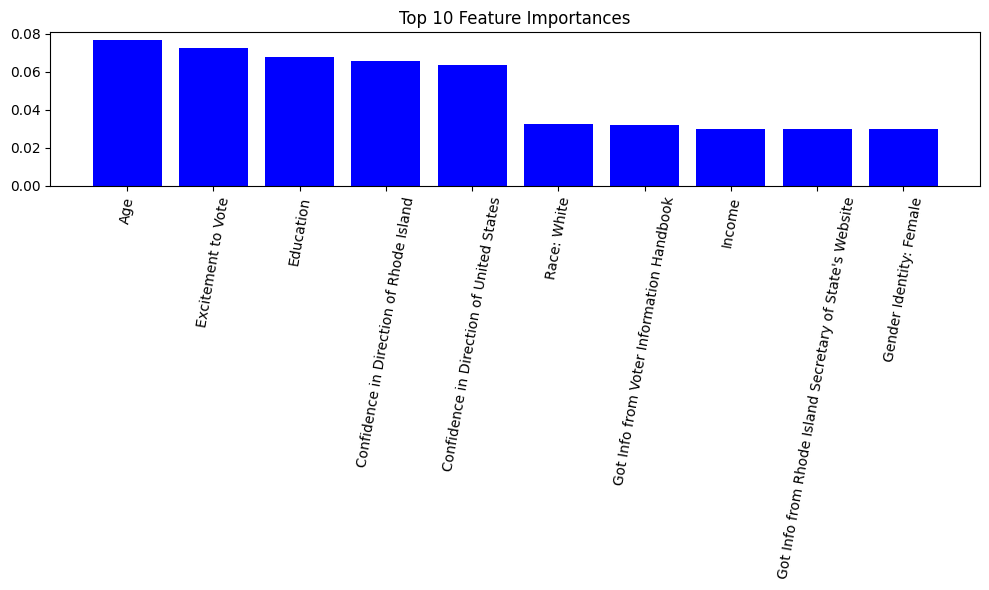

In [ ]:
# --- Feature Importance from RandomForest ---
import numpy as np
import matplotlib.pyplot as plt

importances = rf_model.feature_importances_
feature_names = features_df.rename(columns={
    "conf_dir_ri": "Confidence in Direction of Rhode Island",
    "age": "Age",
    "conf_dir_us": "Confidence in Direction of United States",
    "education": "Education",
    "excited_vote": "Excitement to Vote",
    "Who did you vote for President_Kamala Harris": "Voted for Kamala Harris",
    "info_The Voter Information Handbook sent to my house": "Got Info from Voter Information Handbook",
    "race_White": "Race: White",
    "income": "Income",
    "What is your gender identity?_Female": "Gender Identity: Female",
    "info_Rhode Island Secretary of State's Website": "Got Info from Rhode Island Secretary of State's Website"
    })
feature_names=feature_names.columns
indices = np.argsort(importances)[::-1]

top_n = 10
top_indices = indices[:top_n]

print("Top 10 Feature Importances:")
for i in top_indices:
    print(f"{feature_names[i]}: {importances[i]:.4f}")

plt.figure(figsize=(10,6))
plt.title("Top 10 Feature Importances")
plt.bar(range(top_n), importances[top_indices], color='b', align='center')
plt.xticks(range(top_n), feature_names[top_indices], rotation=80)
plt.tight_layout()
plt.show()

In [ ]:
# voter demographics

features_df = pd.concat([
    ward_df,
    age_df,
    gender_df,
    race_df,
    edu_df,
    income_df,
    pol_df
], axis=1)

X = features_df.values
y = df['outcome_bin'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6944444444444444

Classification Report:
               precision    recall  f1-score   support

           0       0.17      0.08      0.11        25
           1       0.76      0.88      0.82        83

    accuracy                           0.69       108
   macro avg       0.46      0.48      0.46       108
weighted avg       0.62      0.69      0.65       108



In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_y_true = []
all_y_pred = []

for train_idx, test_idx in kf.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_test)

    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

print("Aggregated Classification Report for Same-Day Registration:")
print(classification_report(all_y_true, all_y_pred, digits=2))

Aggregated Classification Report for Same-Day Registration:
              precision    recall  f1-score   support

           0       0.16      0.06      0.09        84
           1       0.76      0.90      0.82       273

    accuracy                           0.71       357
   macro avg       0.46      0.48      0.46       357
weighted avg       0.62      0.71      0.65       357



Feature importances:
age: 0.1849
education: 0.1760
income: 0.0762
race_White: 0.0446
What is your gender identity?_Female: 0.0443
How would you describe your political affiliation?_Democrat: 0.0426
What is your gender identity?_Male: 0.0355
ward_3: 0.0323
ward_6: 0.0322
race_Hispanic or Latino/a: 0.0318
ward_1: 0.0298
ward_8: 0.0296
ward_5: 0.0283
How would you describe your political affiliation?_Independent: 0.0275
How would you describe your political affiliation?_Republican: 0.0263
ward_14: 0.0244
race_Black or African American: 0.0231
ward_9: 0.0217
ward_15: 0.0191
ward_12: 0.0119
race_Other: 0.0104
ward_7: 0.0095
race_Asian: 0.0088
race_American Indian or Alaska Native: 0.0080
How would you describe your political affiliation?_Other third party: 0.0080
ward_11: 0.0062
race_Native Hawaiian or Pacific Islander: 0.0035
What is your gender identity?_Non-binary / Other: 0.0033
What is your gender identity?_Prefer not to say: 0.0000


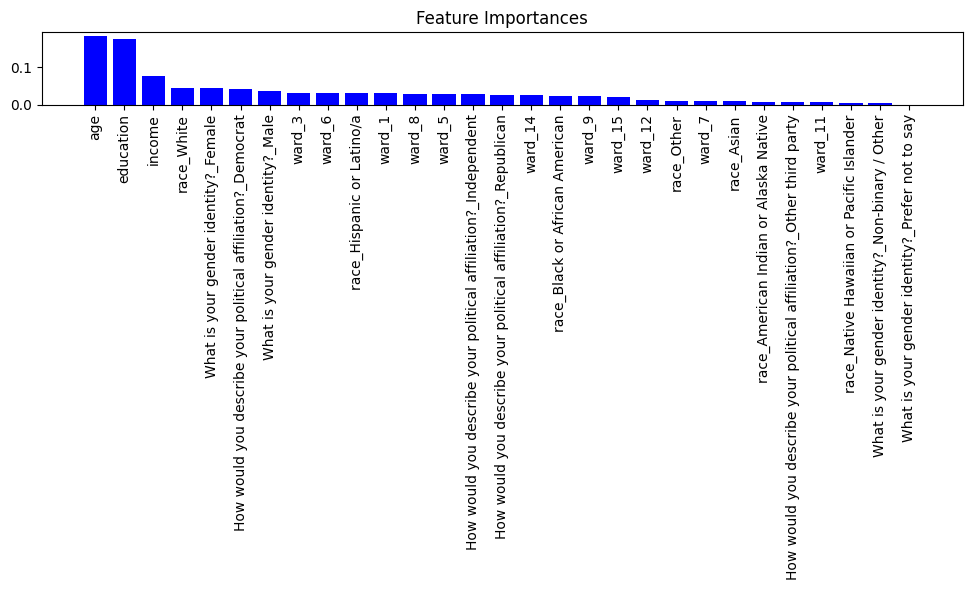

In [ ]:
# --- Feature Importance from RandomForest ---
import numpy as np
import matplotlib.pyplot as plt

importances = rf_model.feature_importances_
feature_names = features_df.columns
indices = np.argsort(importances)[::-1]

print("Feature importances:")
for i in indices:
    print(f"{feature_names[i]}: {importances[i]:.4f}")

plt.figure(figsize=(10,6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], color='b', align='center')
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# voter confidence

features_df = pd.concat([
    conf_dir_us_df,
    conf_dir_ri_df,
    conf_pol_care_df,
    conf_elect_management_df,
    conf_elect_results_df
], axis=1)

X = features_df.values
y = df['outcome_bin'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7962962962962963

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.28      0.39        25
           1       0.81      0.95      0.88        83

    accuracy                           0.80       108
   macro avg       0.73      0.62      0.63       108
weighted avg       0.77      0.80      0.76       108



In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_y_true = []
all_y_pred = []

for train_idx, test_idx in kf.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_test)

    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

print("Aggregated Classification Report for Same-Day Registration:")
print(classification_report(all_y_true, all_y_pred, digits=2))

Aggregated Classification Report for Same-Day Registration:
              precision    recall  f1-score   support

           0       0.33      0.14      0.20        84
           1       0.78      0.91      0.84       273

    accuracy                           0.73       357
   macro avg       0.55      0.53      0.52       357
weighted avg       0.67      0.73      0.69       357



Feature importances:
conf_dir_us: 0.4205
conf_dir_ri: 0.3511
conf_local_vot_off: 0.1021
conf_politicians_ri: 0.0706
conf_election_results: 0.0557


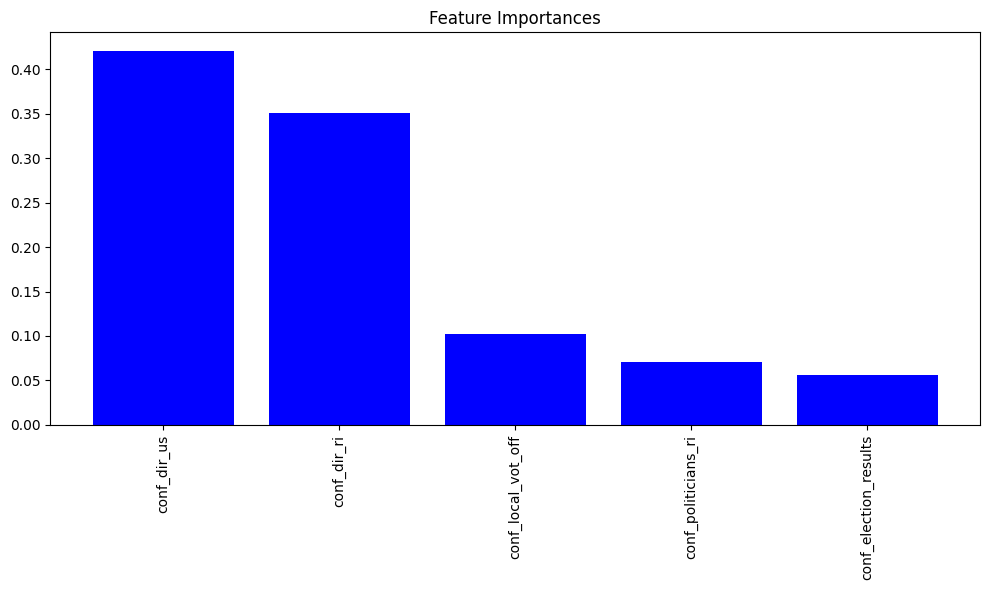

In [ ]:
# --- Feature Importance from RandomForest ---
import numpy as np
import matplotlib.pyplot as plt

importances = rf_model.feature_importances_
feature_names = features_df.columns
indices = np.argsort(importances)[::-1]

print("Feature importances:")
for i in indices:
    print(f"{feature_names[i]}: {importances[i]:.4f}")

plt.figure(figsize=(10,6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], color='b', align='center')
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# voter behavior

features_df = pd.concat([
    pres_vote_df,
    excited_vote_df,
    info_sources_df,
    inperson_reason_df
], axis=1)

X = features_df.values
y = df['outcome_bin'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7314814814814815

Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.16      0.22        25
           1       0.78      0.90      0.84        83

    accuracy                           0.73       108
   macro avg       0.56      0.53      0.53       108
weighted avg       0.68      0.73      0.69       108



In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_y_true = []
all_y_pred = []

for train_idx, test_idx in kf.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_test)

    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

print("Aggregated Classification Report for Same-Day Registration:")
print(classification_report(all_y_true, all_y_pred, digits=2))

Aggregated Classification Report for Same-Day Registration:
              precision    recall  f1-score   support

           0       0.38      0.17      0.23        84
           1       0.78      0.92      0.84       273

    accuracy                           0.74       357
   macro avg       0.58      0.54      0.54       357
weighted avg       0.69      0.74      0.70       357



In [ ]:
# significant features

features_df = pd.concat([
    age_df,
    conf_dir_ri_df,
    conf_dir_us_df,
    edu_df,
    excited_vote_df
], axis=1)

X = features_df.values
y = df['outcome_bin'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7314814814814815

Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.24      0.29        25
           1       0.79      0.88      0.83        83

    accuracy                           0.73       108
   macro avg       0.58      0.56      0.56       108
weighted avg       0.70      0.73      0.71       108



In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_y_true = []
all_y_pred = []

for train_idx, test_idx in kf.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_test)

    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

print("Aggregated Classification Report for Same-Day Registration:")
print(classification_report(all_y_true, all_y_pred, digits=2))

Aggregated Classification Report for Same-Day Registration:
              precision    recall  f1-score   support

           0       0.31      0.15      0.21        84
           1       0.77      0.89      0.83       273

    accuracy                           0.72       357
   macro avg       0.54      0.52      0.52       357
weighted avg       0.67      0.72      0.68       357



Feature importances:
education: 0.2394
age: 0.2200
excited_vote: 0.2002
conf_dir_us: 0.1712
conf_dir_ri: 0.1692


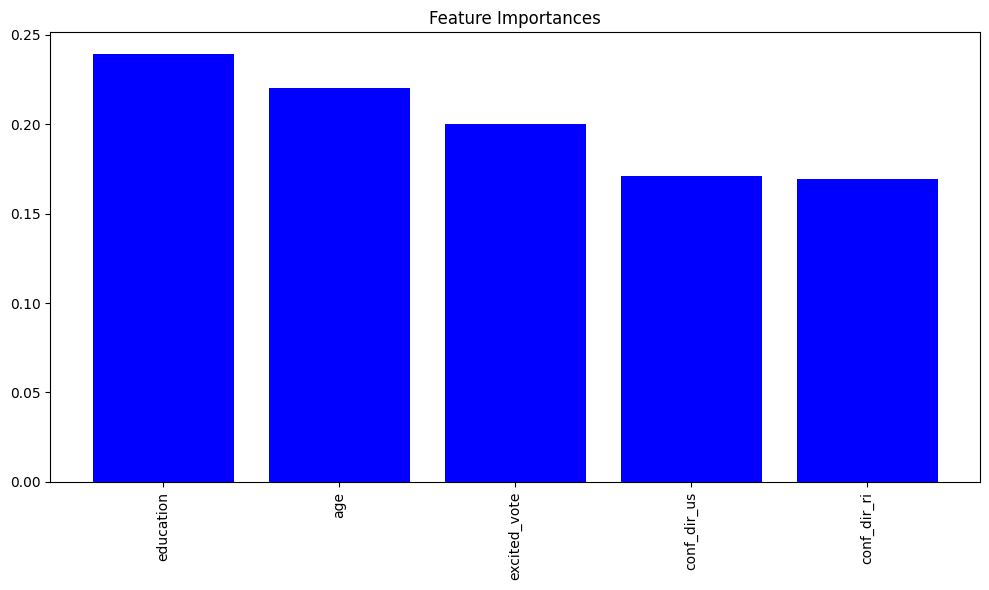

In [ ]:
importances = rf_model.feature_importances_
feature_names = features_df.columns
indices = np.argsort(importances)[::-1]

print("Feature importances:")
for i in indices:
    print(f"{feature_names[i]}: {importances[i]:.4f}")

plt.figure(figsize=(10,6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], color='b', align='center')
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

Support rate by ward:
   ward_str  outcome_bin
0         1     0.737705
5         3     0.764706
6         5     0.755102
7         6     0.666667
8         7     0.750000
9         8     0.770833
10        9     0.933333
1        11     0.909091
2        12     0.733333
3        14     0.761905
4        15     0.761905


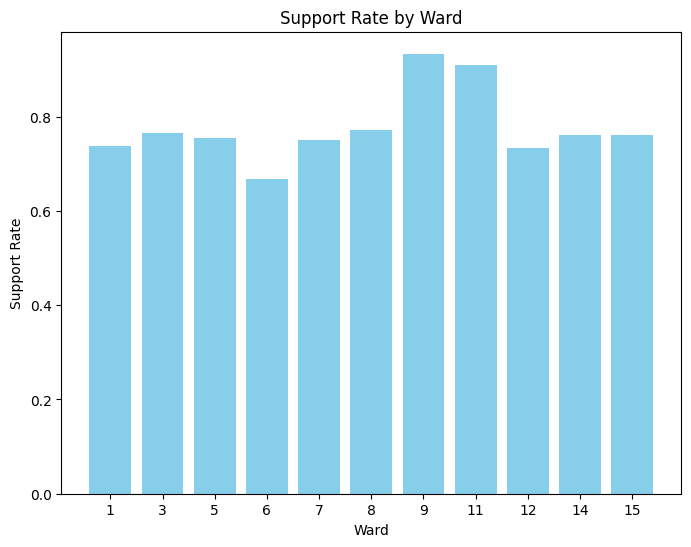

In [ ]:
import matplotlib.pyplot as plt

ward_support = df.groupby('ward')['outcome_bin'].mean().reset_index()

ward_support['ward_num'] = ward_support['ward'].astype(float).astype(int)
ward_support = ward_support.sort_values(by='ward_num')
ward_support['ward_str'] = ward_support['ward_num'].astype(str)

print("Support rate by ward:")
print(ward_support[['ward_str', 'outcome_bin']])

plt.figure(figsize=(8,6))
plt.bar(ward_support['ward_str'],
        ward_support['outcome_bin'],
        color='skyblue')
plt.xlabel('Ward')
plt.ylabel('Support Rate')
plt.title('Support Rate by Ward')
plt.xticks(rotation=0)
plt.show()

Support rate by age group:
  What is your age group?  outcome_bin
0                   18-24     0.800000
1                   25-29     0.796296
2                   30-39     0.783505
3                   40-49     0.714286
4                   50-64     0.808219
5             65 or older     0.600000


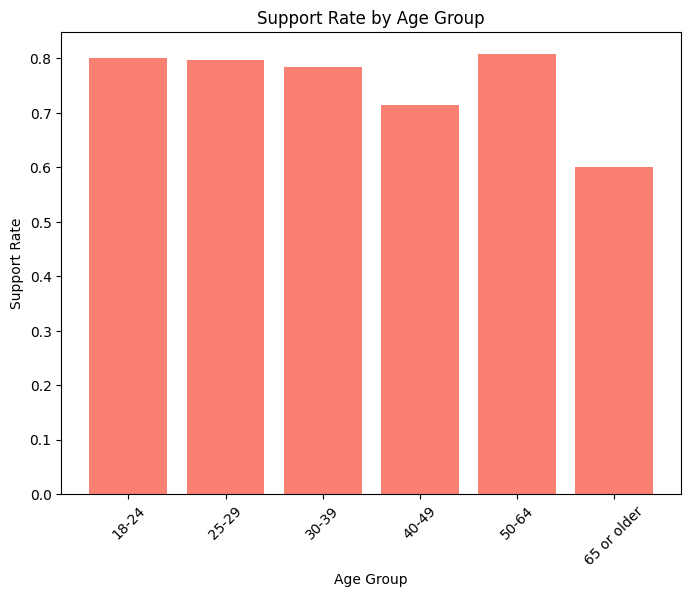

In [ ]:
age_support = df.groupby('What is your age group?')['outcome_bin'].mean().reset_index()
print("Support rate by age group:")
print(age_support)

plt.figure(figsize=(8,6))
plt.bar(age_support['What is your age group?'], age_support['outcome_bin'], color='salmon')
plt.xlabel('Age Group')
plt.ylabel('Support Rate')
plt.title('Support Rate by Age Group')
plt.xticks(rotation=45)
plt.show()

Support rate by education:
  What is your highest level of education?  outcome_bin
0                            2 year degree     0.550000
1                            4 year degree     0.739130
2                                Doctorate     0.789474
3               High school graduate / GED     0.818182
4                    Less than High School     0.875000
5                      Professional degree     0.786667
6                             Some college     0.762500


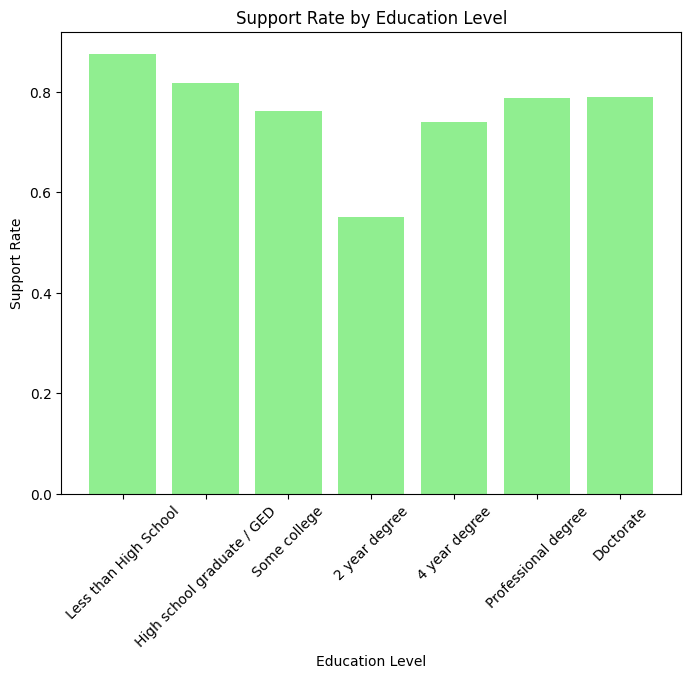

In [ ]:
edu_support = df.groupby(q_education)['outcome_bin'].mean().reset_index()
print("Support rate by education:")
print(edu_support)

edu_support[q_education] = pd.Categorical(edu_support[q_education],
                                          categories=education_order,
                                          ordered=True)
edu_support = edu_support.sort_values(by=q_education)

plt.figure(figsize=(8,6))
plt.bar(edu_support[q_education], edu_support['outcome_bin'], color='lightgreen')
plt.xlabel('Education Level')
plt.ylabel('Support Rate')
plt.title('Support Rate by Education Level')
plt.xticks(rotation=45)
plt.show()

Support rate by conf_dir_us:
Overall, do you feel that the country is heading in the right direction or the wrong direction?
Definitely Wrong    0.683544
Somewhat Wrong      0.802083
Unsure              0.810345
Somewhat Right      0.732673
Definitely Right    0.913043
Name: outcome_bin, dtype: float64


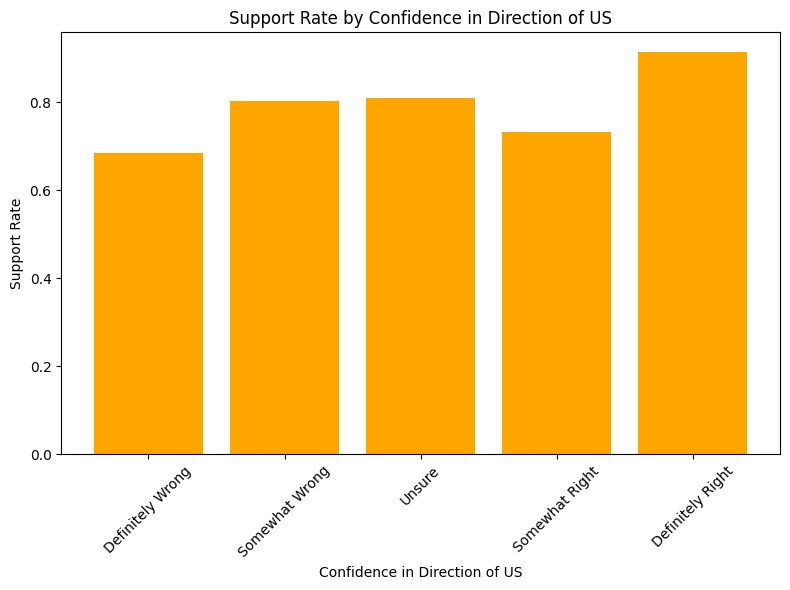

Support rate by conf_dir_ri:
Overall, do you feel that Rhode Island is heading in the right direction or the wrong direction?
Definitely Wrong    0.545455
Somewhat Wrong      0.729730
Unsure              0.784314
Somewhat Right      0.813665
Definitely Right    0.888889
Name: outcome_bin, dtype: float64


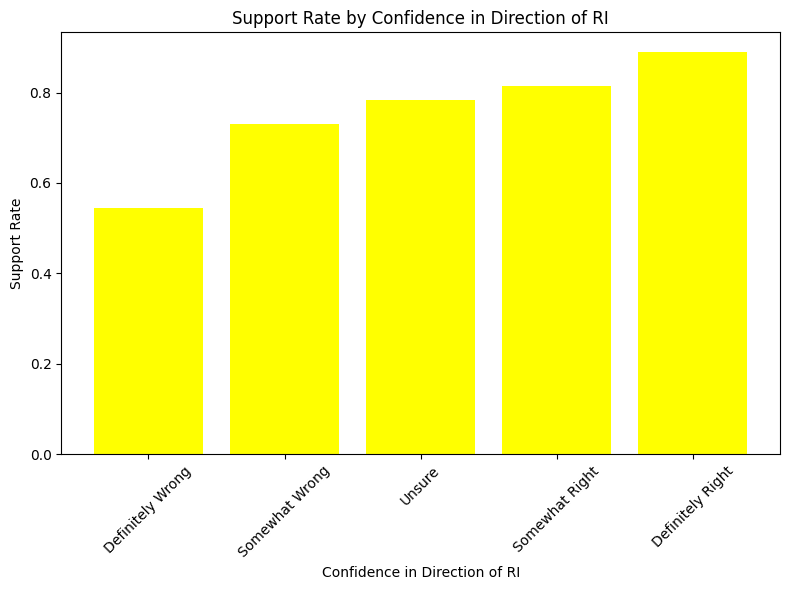

Support rate by excited_vote_:
Were you excited to vote for your presidential candidate?
Not at all Excited    0.782609
Not Very Excited      0.720930
Somewhat Excited      0.778947
Very Excited          0.807229
Extremely Excited     0.734513
Name: outcome_bin, dtype: float64


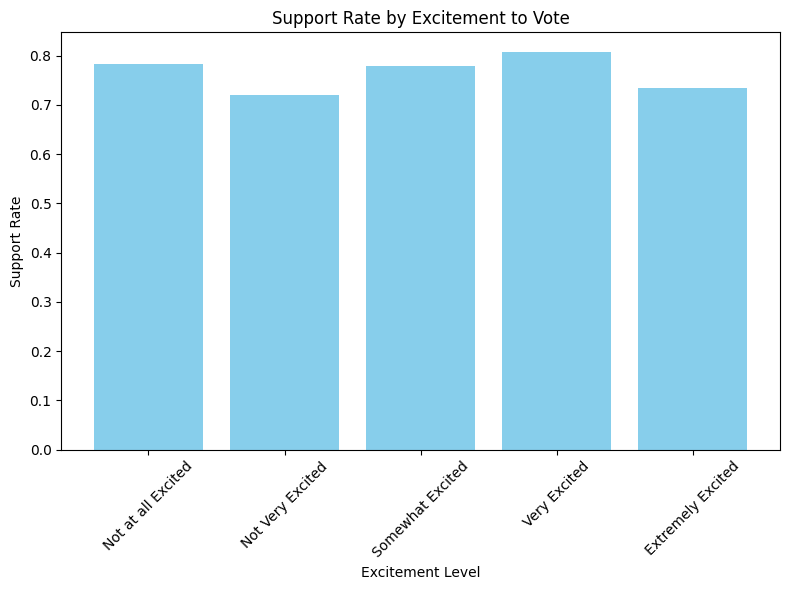

In [ ]:
# confidence in direction of US vs support for policies
conf_dir_us_support = df.groupby(q_conf_dir_us)['outcome_bin'].mean().reindex(confidence_order)
print("Support rate by conf_dir_us:")
print(conf_dir_us_support)

conf_dir_us_support_df = conf_dir_us_support.reset_index()
conf_dir_us_support_df[q_conf_dir_us] = pd.Categorical(
    conf_dir_us_support_df[q_conf_dir_us],
    categories=confidence_order,
    ordered=True
)
conf_dir_us_support_df.sort_values(by=q_conf_dir_us, inplace=True)

plt.figure(figsize=(8, 6))
plt.bar(conf_dir_us_support_df[q_conf_dir_us], conf_dir_us_support_df['outcome_bin'], color='orange')
plt.xlabel('Confidence in Direction of US')
plt.ylabel('Support Rate')
plt.title('Support Rate by Confidence in Direction of US')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# confidence in direction of RI vs support for policies
conf_dir_ri_support = df.groupby(q_conf_dir_ri)['outcome_bin'].mean().reindex(confidence_order)
print("Support rate by conf_dir_ri:")
print(conf_dir_ri_support)

conf_dir_ri_support_df = conf_dir_ri_support.reset_index()
conf_dir_ri_support_df[q_conf_dir_ri] = pd.Categorical(
    conf_dir_ri_support_df[q_conf_dir_ri],
    categories=confidence_order,
    ordered=True
)
conf_dir_ri_support_df.sort_values(by=q_conf_dir_ri, inplace=True)

plt.figure(figsize=(8, 6))
plt.bar(conf_dir_ri_support_df[q_conf_dir_ri], conf_dir_ri_support_df['outcome_bin'], color = 'yellow')
plt.xlabel('Confidence in Direction of RI')
plt.ylabel('Support Rate')
plt.title('Support Rate by Confidence in Direction of RI')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# excitement to vote vs support for policies
excited_vote_support = df.groupby(q_excited_vote)['outcome_bin'].mean().reindex(excitement_order)
print("Support rate by excited_vote_:")
print(excited_vote_support)

excited_vote_support_df = excited_vote_support.reset_index()
excited_vote_support_df[q_excited_vote] = pd.Categorical(
    excited_vote_support_df[q_excited_vote],
    categories=excitement_order,
    ordered=True
)
excited_vote_support_df.sort_values(by=q_excited_vote, inplace=True)

plt.figure(figsize=(8, 6))
plt.bar(excited_vote_support_df[q_excited_vote], excited_vote_support_df['outcome_bin'], color = 'skyblue')
plt.xlabel('Excitement Level')
plt.ylabel('Support Rate')
plt.title('Support Rate by Excitement to Vote')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()